### <img src="icons/resized/library.png" style="height:50px;display:inline"> Libs

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
import random
from tqdm.notebook import tqdm

from torchsummary import summary

### <img src="icons/resized/helper_functions.png" style="height:50px;display:inline"> Useful Functions and utils
1)  train_model_for_test - training method, receives the model, train loader nd some hyper-parameters. 
    Calculates training loss and accuracy for each epoch in the training process and returns a trained model.
2)  calculate_accuracy - calculates the model accuracy given a train loader. Returns the accuracy results.
3)  feature_extract_or_fine_tuning - Decide which parameters needs to be trained depending on the modes that
    the user choose (fine tuning or feature extract).
4)  ViT_utils - contains some image processing functions for the image pre-processing explanations. 

In [13]:
from utils import ViT_utils as V_ut

def train_model_for_test(model, trainloader, epochs, learning_rate, model_loss, model_accuracy, model_name_to_save):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for epoch in tqdm(range(1, epochs + 1, 1), leave=True):
        model.train()  # put in training mode, turn on Dropout, BatchNorm uses batch's statistics
        running_loss = 0.0
        epoch_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward pass
            
            loss = criterion(outputs, labels)  # calculate the loss
            
            optimizer.zero_grad()  # zero the parameter gradients
            loss.backward()  # backpropagation
            optimizer.step()  # update parameters

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)
        model_loss.append(running_loss)

        # Calculate training/test set accuracy of the existing model
        train_accuracy, _ = V_ut.calculate_accuracy(model, trainloader, device)
        model_accuracy.append(train_accuracy)
        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

        # save model
        if epoch % 10 == 0:
            print('==> Saving model ...')
            state = {
                'net': model.state_dict(),
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, f'./checkpoints/{model_name_to_save}.pth')

    print('==> Finished Training ...')
    
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([38, 38], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

    
def feature_extract_or_fine_tuning(model, feature_extract=True):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = [] # override the initial list definition above
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    #return model


### <img src="icons/resized/device.png" style="height:50px;display:inline"> Device

In [3]:
if torch.backends.mps.is_built():
    print("using MPS")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("using Cuda")
    device = torch.device("cuda:0")
else:
    print("using CPUֹ")
    device = torch.device("cpu")

using MPS


### <img src="icons/resized/dataset.png" style="height:50px;display:inline"> Dataset
Loading dataset as train, validation and test:

train dataset has 39116 samples
validation dataset has 10861 samples
test dataset has 4328 samples


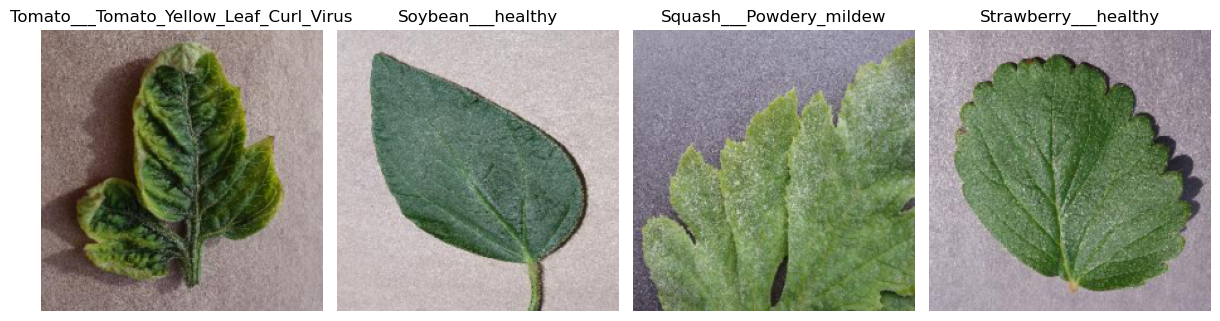

In [18]:
local_root_dir = 'Dataset/PlantVillage 2'

dataset_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])


train_set = datasets.ImageFolder(root=local_root_dir + '/train', transform=dataset_transform)
valid_set = datasets.ImageFolder(root=local_root_dir + '/val', transform=dataset_transform)
test_set = datasets.ImageFolder(root=local_root_dir + '/test', transform=dataset_transform)

train_size = len(train_set)
valid_size = len(valid_set)
test_size = len(test_set)


print(f"train dataset has {train_size} samples\nvalidation dataset has {valid_size} samples\ntest dataset has {test_size} samples")

sample_dataset_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=4, shuffle=True)

iterator = iter(sample_dataset_loader)

batch_images, batch_labels = next(iterator)
fig, axes = plt.subplots(1, len(batch_images), figsize=(12, 4))
for i, image in enumerate(batch_images):
    axes[i].imshow(image.permute(1, 2, 0))  # permute to (H, W, C) for display
    axes[i].axis('off')
    axes[i].set_title(train_set.classes[batch_labels[i]])
plt.tight_layout()
plt.show()


### <img src="icons/resized/explanations.png" style="height:50px;display:inline"> Image Preprocessing explanations
According to the paper it is required to split the input images to patches. We will use the same size as suggested - 16x16 patches.
The images are with size of (224,224), therefore each image will have $\frac{224}{16}$ $\cdot$ $\frac{224}{16}$ = $14$$\cdot$$14$ = $196$ patches.
After we patched the image, we need to make it looks more like a sequence, so we will flatten the tensor (image) to 196$\times$768 tensor, where 196 represents the number of patches and 768 represents the flattened tensor of each patch: $\underbrace{\text{16}}_{\Large\text(1)}$ $\times$ $\underbrace{\text{16}}_{\Large\text(2)}$ $\times$ $\underbrace{\text{3}}_{\Large\text(3)}$
$(1)  \text{Patch width}$
$(2)  \text{Patch height}$
$(3)  \text{Patch channels}$
From here we understand that the embedding dimension would be 768.

choosing random picture from the train set...
shape of the image divided to patches: torch.Size([196, 3, 16, 16])


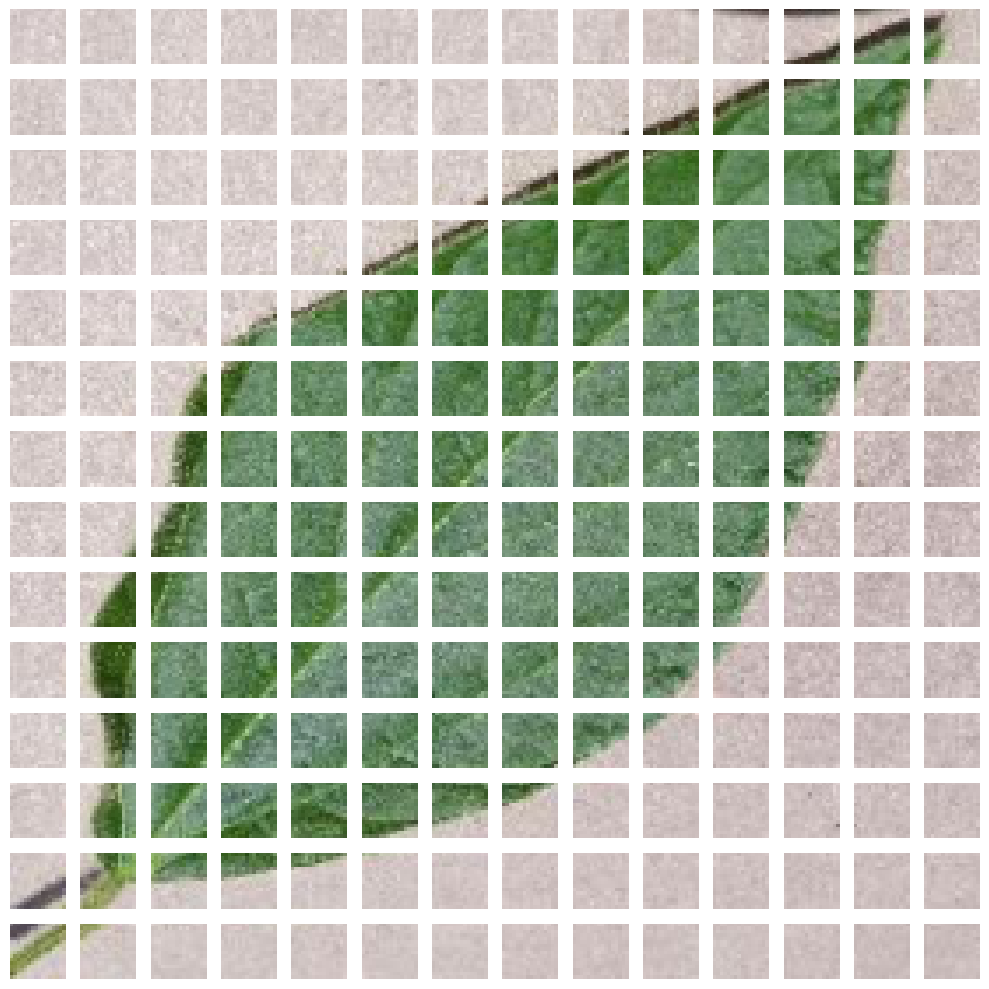

shape of the sequenced patch: torch.Size([196, 768])


In [19]:
print('choosing random picture from the train set...')
random_picture_idx = random.randint(0, len(train_set) - 1)
picture_position = 0
output_patched_image = V_ut.divide_to_patches(train_set[random_picture_idx][picture_position])
print(f'shape of the image divided to patches: {output_patched_image.shape}')
V_ut.show_image_patches(output_patched_image)
sequenced_patch = V_ut.flatten_patch_to_sequence(output_patched_image)
print(f'shape of the sequenced patch: {sequenced_patch.shape}')
V_ut.show_sequenced_patch(output_patched_image)

### <img src="icons/resized/transfer.png" style="height:50px;display:inline"> Transfer Learning
Now that we understand the preprocessing of the input image, the image is passed the encoder. from the encoder the output is passed to a MLP layer and finally get the classification of the input image into one of our possible classes.
We will use a pre-trained model of ViT and use transfer learning for our task - plants classification and their health status.

In [20]:
# get the weights of pre-trained model. DEFAULT = IMAGENET1K_V1
ViT_pre_trained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# define ViT pre-trained model with DEFAULT weights.
ViT_pre_trained_model = torchvision.models.vit_b_16(weights=ViT_pre_trained_weights)

# we need to use the same transform on our dataset so the 
ViT_transform = ViT_pre_trained_weights.transforms()

train_set = datasets.ImageFolder(root=local_root_dir + '/train', transform=ViT_transform)
valid_set = datasets.ImageFolder(root=local_root_dir + '/val', transform=ViT_transform)
test_set = datasets.ImageFolder(root=local_root_dir + '/test', transform=ViT_transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

### <img src="icons/resized/adaptation.png" style="height:50px;display:inline"> Feature Extract

In [23]:
# define our model
mlp_fine_tune_model = ViT_pre_trained_model

# freezing the base params
for param in mlp_fine_tune_model.parameters():
    param.requires_grad = False
    
print(mlp_fine_tune_model)
print(f"locating the mlp layer that needs to be adapted for our specific task - {mlp_fine_tune_model.heads}")
print(f"will change it from 1000 classes to {len(train_set.classes)} classes")

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [25]:
# changing the mlp layer to match for the new task - plants classification
mlp_fine_tune_model.heads = nn.Linear(in_features=768, out_features=len(train_set.classes), bias=True)

feature_extract_or_fine_tuning(mlp_fine_tune_model, feature_extract=True)

print(f"MLP layer - {mlp_fine_tune_model.heads}")

Params to learn:
	 heads.weight
	 heads.bias
MLP layer - Linear(in_features=768, out_features=38, bias=True)


In [26]:
mlp_fine_tune_model.to(device)

mlp_fine_tune_model_loss = []
mlp_fine_tune_model_accuracy = []
epochs = 10
lr = 0.001
train_model_for_test(mlp_fine_tune_model, train_loader, epochs, lr, mlp_fine_tune_model_loss, mlp_fine_tune_model_accuracy, "ViT_mlp_fine_tune_model")

 10%|█         | 1/10 [21:58<3:17:50, 1318.97s/it]

Epoch: 1 | Loss: 0.4448 | Training accuracy: 97.060% | Epoch Time: 1318.96 secs


 20%|██        | 2/10 [44:01<2:56:07, 1320.95s/it]

Epoch: 2 | Loss: 0.1144 | Training accuracy: 98.162% | Epoch Time: 1322.32 secs


 30%|███       | 3/10 [1:06:04<2:34:14, 1322.06s/it]

Epoch: 3 | Loss: 0.0753 | Training accuracy: 98.867% | Epoch Time: 1323.37 secs


 40%|████      | 4/10 [1:28:04<2:12:07, 1321.21s/it]

Epoch: 4 | Loss: 0.0569 | Training accuracy: 99.046% | Epoch Time: 1319.90 secs


 50%|█████     | 5/10 [1:49:30<1:49:03, 1308.61s/it]

Epoch: 5 | Loss: 0.0452 | Training accuracy: 99.369% | Epoch Time: 1286.25 secs


 60%|██████    | 6/10 [2:10:56<1:26:43, 1300.94s/it]

Epoch: 6 | Loss: 0.0373 | Training accuracy: 99.491% | Epoch Time: 1286.03 secs


 70%|███████   | 7/10 [2:32:23<1:04:48, 1296.10s/it]

Epoch: 7 | Loss: 0.0308 | Training accuracy: 99.599% | Epoch Time: 1286.13 secs


 80%|████████  | 8/10 [2:53:49<43:05, 1292.90s/it]  

Epoch: 8 | Loss: 0.0263 | Training accuracy: 99.496% | Epoch Time: 1286.04 secs


 90%|█████████ | 9/10 [3:15:16<21:31, 1291.33s/it]

Epoch: 9 | Loss: 0.0230 | Training accuracy: 99.637% | Epoch Time: 1287.88 secs
Epoch: 10 | Loss: 0.0202 | Training accuracy: 99.808% | Epoch Time: 1286.65 secs
==> Saving model ...


100%|██████████| 10/10 [3:36:44<00:00, 1300.43s/it]

==> Finished Training ...


In [27]:
test_accuracy, _ = calculate_accuracy(mlp_fine_tune_model, test_loader, device)
print(f"test accuracy:{test_accuracy}")

test accuracy:98.63678373382625


In [21]:
def add_gaussian_noise_tensor(tensor, mean=0, std=0.02):
    noise = torch.randn_like(tensor) * std + mean
    noisy_tensor = tensor + noise
    return noisy_tensor

# Define the mean and standard deviation for Gaussian noise
mean_value = 0  # Mean of the Gaussian noise
std_value = 0.1  # Standard deviation of the Gaussian noise

# Define the transform function using transforms.Lambda
noisy_transform = transforms.Compose([
    transforms.Lambda(lambda x: add_gaussian_noise_tensor(x, mean=mean_value, std=std_value)),  # Add Gaussian noise to the dataset 
])

noisy_test_transform = transforms.Compose([
    transforms.ToTensor(),
    noisy_transform,
    ViT_transform,
])

In [22]:
# load our ViT trained model:
ViT_model_pre_trained = torchvision.models.vit_b_16(weights=ViT_pre_trained_weights)
ViT_model_pre_trained.heads = nn.Linear(in_features=768, out_features=len(train_set.classes), bias=True)
ViT_model_loaded = ViT_model_pre_trained
if os.path.isfile('checkpoints/ViT_mlp_fine_tune_model.pth'):
    checkpoint = torch.load('checkpoints/ViT_mlp_fine_tune_model.pth')
    ViT_model_loaded.load_state_dict(checkpoint['net'])
    epoch = checkpoint['epoch']
ViT_model_loaded.to(device)

test_results = []
std_values = [0, 0.05, 0.07, 0.09, 0.1]

batch_size = 64
for std in std_values:
    std_value = std
    noisy_test_dataset = datasets.ImageFolder(root=local_root_dir + '/test/', transform=noisy_test_transform)
    noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)
    test_accuracy, _ = calculate_accuracy(ViT_model_loaded, noisy_test_loader, device)
    test_results.append(test_accuracy)
    print(f"std: {std} test accuracy:{test_accuracy}")

std: 0 test accuracy:98.63678373382625
std: 0.05 test accuracy:95.19408502772643
std: 0.07 test accuracy:92.32902033271719
std: 0.09 test accuracy:88.1007393715342
std: 0.1 test accuracy:85.25878003696857


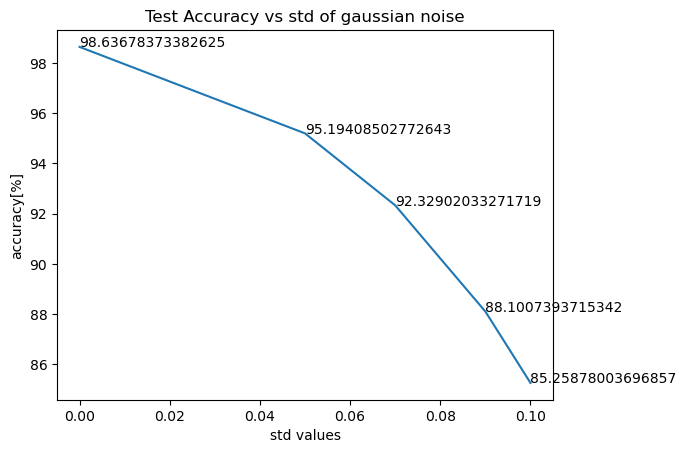

In [23]:
fig, ax = plt.subplots()
ax.plot(std_values, test_results)
ax.set_title('Test Accuracy vs std of gaussian noise')
ax.set_xlabel('std values')
ax.set_ylabel('accuracy[%]')
for i, txt in enumerate(test_results):
    plt.annotate(txt, (std_values[i], test_results[i]))
plt.show()